# Attention Demo Notebook
Comprehension notebook to explain the details of the attention mechanism.

In [1]:
from dataclasses import dataclass
import inspect
import math
import sys
from typing import Optional

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch import Tensor


## General Single Head Attention

Given input $ X \in R[B, T, C]$ we compute the attention <br>

$$ \text{Attention(Q, K, V)} = \text{softmax}({\frac{QK^T}{\sqrt{\text{n emb}}}}) V $$

where

$$Q = XW_q + b_q$$
$$K = XW_k + b_k$$
$$V = XW_v + b_v$$

### Config

In [85]:
@dataclass
class AttentionConfig:
    batch_size: int = 1 # Added for demo purposes
    block_size: int = 5
    vocab_size: int = 65  # GPT-2 use 50304
    n_head: int = 1
    n_embd: int = 2

config = AttentionConfig()

### Single Generalized Attention Head

The attention head expects an input tensor of shape $(\text{batch size}, \text{block size}, \text{n emb})$

In [3]:
x = torch.rand(size=(config.batch_size, config.block_size, config.n_embd))
(
    B,
    T,
    C,
) = x.size()
print(x.size())

torch.Size([1, 5, 2])


First, we apply a linear transformation of the input tensor to generate the Query, Key, and Value matrices <br>

$$Q = XW_q + b_q$$
$$K = XW_k + b_k$$
$$V = XW_v + b_v$$

Where $W_i$ is a matrix of shape $(\text{n emb}, \text{n emb})$.

In [4]:
# Configure linear transformation, note that this is a 2x2 matrix
c_attn = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
c_attn

Linear(in_features=2, out_features=2, bias=True)

Linear Transformation in Attention Head Input for Query Vector
![Linear Transformation](images/linear_transformation.png)

In [5]:
# Apply linear transformation for Q, K, V
q, k, v = c_attn(x), c_attn(x), c_attn(x)
# Note the batch size dimension, which in this case is 1, but otherwise has an 
# additional independent dimension on which to apply the attention operation.
print(q.shape, k.shape, v.shape)

torch.Size([1, 5, 2]) torch.Size([1, 5, 2]) torch.Size([1, 5, 2])


In [7]:
# check on q
q

tensor([[[-0.0883, -0.5549],
         [-0.1099, -0.2631],
         [ 0.0440, -0.0515],
         [-0.0147, -0.4408],
         [-0.1041, -0.5438]]], grad_fn=<ViewBackward0>)

Next, we compute the scores between the queries and keys
$$S = QK^T$$
where $S$ is a matrix of shape $(\text{block size}, \text{block size})$. Since we use an additional dimension for the batch, this matrix shape is actually $(\text{batch size}, \text{block size}, \text{block size})$. Note that we need to transpose the K tensor along the block and embedding dimensions for this to work.

Attention Matrix Visualization in Torch MM
![Attention Matrix](images/attention_matrix.png)

In [8]:
print(q.shape, k.shape, k.transpose(2, 1).shape)
print((q @ k.transpose(-2, -1)).shape)

torch.Size([1, 5, 2]) torch.Size([1, 5, 2]) torch.Size([1, 2, 5])
torch.Size([1, 5, 5])


Next, we want to scale down the score matrix by the square root of the embedding dimension to prevent exploding values in the softmax function, which is visualziad below.

$$S_{\text{scaled}} = \frac{QK^T}{\sqrt{\text{n emb}}}$$

And apply a softmax function

$$P = \text{softmax}({\frac{QK^T}{\sqrt{\text{n emb}}}})$$

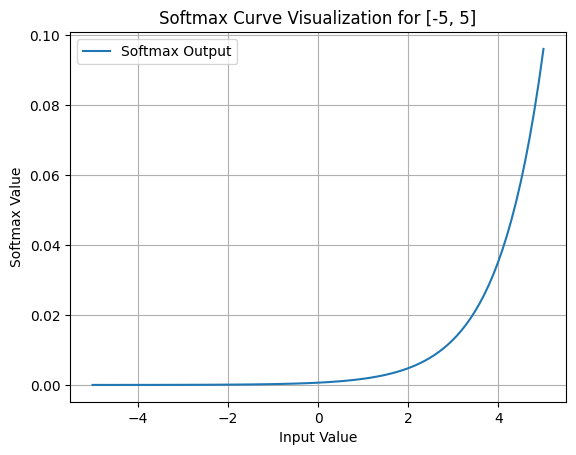

In [9]:
# Softmax Demo
x = torch.linspace(-5, 5, 100)    
# Compute softmax values using PyTorch's built-in function for each value
y = F.softmax(x, dim=0).numpy()

# Plotting
plt.plot(x.numpy(), y, label="Softmax Output")
plt.xlabel('Input Value')
plt.ylabel('Softmax Value')
plt.title('Softmax Curve Visualization for [-5, 5]')
plt.legend()
plt.grid(True)
plt.show()

In [56]:
# Scaled Attention Matrix
attn = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
print(attn.shape)
attn

torch.Size([1, 5, 5])


tensor([[[0.0951, 0.1784, 0.0491, 0.0629, 0.1611],
         [0.1784, 0.3387, 0.0857, 0.1142, 0.3047],
         [0.0491, 0.0857, 0.0356, 0.0386, 0.0794],
         [0.0629, 0.1142, 0.0386, 0.0453, 0.1043],
         [0.1611, 0.3047, 0.0794, 0.1043, 0.2745]]], grad_fn=<MulBackward0>)

In [57]:
# Apply Softmax
attn = F.softmax(attn, dim=-1)
print(attn.shape)
attn

torch.Size([1, 5, 5])


tensor([[[0.1969, 0.2140, 0.1881, 0.1907, 0.2104],
         [0.1939, 0.2276, 0.1767, 0.1818, 0.2200],
         [0.1982, 0.2056, 0.1956, 0.1962, 0.2043],
         [0.1979, 0.2083, 0.1931, 0.1944, 0.2062],
         [0.1945, 0.2246, 0.1793, 0.1838, 0.2179]]],
       grad_fn=<SoftmaxBackward0>)

Finally, we multiply by the scaled attention matrix with the value matrix after applying the softmax function.

$$ \text{Attention(Q, K, V)} = \text{softmax}({\frac{QK^T}{\sqrt{\text{n emb}}}}) V $$

End to End Attention Head Visualization in Torch MM
![Attention](images/end_to_end_attention.png)


In [58]:
att_output = attn @ v
print(att_output.shape)
att_output

torch.Size([1, 5, 2])


tensor([[[-0.3673,  0.2276],
         [-0.3737,  0.2360],
         [-0.3633,  0.2224],
         [-0.3646,  0.2241],
         [-0.3723,  0.2341]]], grad_fn=<UnsafeViewBackward0>)

## GPT Style Single Head Attention

In a generative transformer setup we need to mask the tokens ahead of the current token in the attention head. This is called autoregressive masking.

In [79]:
# Setup as before
x = torch.rand(size=(config.batch_size, config.block_size, config.n_embd))
(B, T, C) = x.size()
c_attn = nn.Linear(config.n_embd, config.n_embd)
q, k, v = c_attn(x), c_attn(x), c_attn(x)

In [80]:
# Generate scaled attention score matrix as before
attn = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
print(attn.shape)
attn

torch.Size([1, 5, 5])


tensor([[[0.3296, 0.3931, 0.2721, 0.3681, 0.4041],
         [0.3931, 0.5319, 0.3320, 0.4099, 0.5622],
         [0.2721, 0.3320, 0.2255, 0.3004, 0.3431],
         [0.3681, 0.4099, 0.3004, 0.4245, 0.4142],
         [0.4041, 0.5622, 0.3431, 0.4142, 0.5976]]], grad_fn=<MulBackward0>)

Next, we define a lower triangular matrix to handle the autoregressive masking.

In [81]:
tril = torch.tril(torch.ones(config.block_size, config.block_size)).view(
    config.block_size, config.block_size
)
tril

tensor([[1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.]])

We apply a mask fill using the triangular matrix using large negative values to cause zero values in the softmax. We can also visualize this in Torch MM.

Autoregressive Attention Matrix Visualization in Torch MM
![Autoregressive Attention Matrix](images/gpt_attention.png)

In [82]:
attn = attn.masked_fill(tril == 0, float("-inf"))
print(attn.shape)
attn

torch.Size([1, 5, 5])


tensor([[[0.3296,   -inf,   -inf,   -inf,   -inf],
         [0.3931, 0.5319,   -inf,   -inf,   -inf],
         [0.2721, 0.3320, 0.2255,   -inf,   -inf],
         [0.3681, 0.4099, 0.3004, 0.4245,   -inf],
         [0.4041, 0.5622, 0.3431, 0.4142, 0.5976]]],
       grad_fn=<MaskedFillBackward0>)

In [83]:
attn = F.softmax(attn, dim=-1)
print(attn.shape)
print(attn)

torch.Size([1, 5, 5])
tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.4654, 0.5346, 0.0000, 0.0000, 0.0000],
         [0.3315, 0.3520, 0.3164, 0.0000, 0.0000],
         [0.2478, 0.2584, 0.2316, 0.2622, 0.0000],
         [0.1874, 0.2195, 0.1763, 0.1893, 0.2274]]],
       grad_fn=<SoftmaxBackward0>)


In [84]:
att_output = attn @ v
print(att_output.shape)
att_output

torch.Size([1, 5, 2])


tensor([[[-0.6481, -0.2146],
         [-0.7651, -0.0852],
         [-0.6929, -0.1069],
         [-0.6895, -0.1765],
         [-0.7448, -0.1075]]], grad_fn=<UnsafeViewBackward0>)

MM PyTorch Demo Link

GPT Attention

https://bhosmer.github.io/mm/index.html?0=out+%3D+%28attn+%3D+%28Q+%3D+input+%40+wQ%29+%40+%28K_T+%3D+W_kT+%40+input_t%29%29+%40+%28V+%3D+input+%40+wV%29+%40+wO&1=out&2=none&14=open&84=true&3.1=attn+%40+V&3.4=true&3.5=32&3.6=32&3.7=row+major&3.8=&3.9=-1&3.10=1&3.11=0&3.2=none&12.13=vmprod&12.14=closed&15.16=1&15.17=1&15.18=1&19.20=positive&19.21=left&19.22=bottom&19.23=back&24.1=attn&24.4=true&24.2=softmax%28tril%28x%2Fsqrt%28k%29%29%29&25.1=Q&25.4=true&25.2=none&26.1=input&26.4=false&26.5=10&26.6=2&26.7=url&26.9=-1&26.10=1&26.11=0&26.8=https%3A%2F%2Fraw.githubusercontent.com%2Fbhosmer%2Ftestdata%2Fmain%2Fweights%2Fgpt2%2Flayer5_input0_256_768.csv&26.0=&26.14=open&27.1=wQ&27.4=false&27.5=2&27.6=2&27.7=url&27.9=-1&27.10=1&27.11=0&27.8=https%3A%2F%2Fraw.githubusercontent.com%2Fbhosmer%2Ftestdata%2Fmain%2Fweights%2Fgpt2%2Flayer5_wq4_768_64.csv&27.0=&27.14=open&28.13=vmprod&28.14=closed&29.16=1&29.17=1&29.18=1&30.20=positive&30.21=left&30.22=bottom&30.23=back&25.14=open&31.2=none&32.13=inherit&33.17=1&33.16=1&33.18=1&34.20=positive&34.21=right&34.22=top&34.23=back&35.1=W_kT&35.4=false&35.5=2&35.6=2&35.7=row+major&35.8=&35.9=-1&35.10=1&35.11=0&35.0=&35.14=open&36.1=input_t&36.4=false&36.5=2&36.6=10&36.7=url&36.8=https%3A%2F%2Fraw.githubusercontent.com%2Fbhosmer%2Ftestdata%2Fmain%2Fweights%2Fgpt2%2Flayer5_input_t0_768_256.csv&36.9=-1&36.10=1&36.11=0&36.0=&36.14=open&31.1=K_T&31.4=true&31.14=open&37.13=vmprod&38.16=1&38.17=1&38.18=1&39.20=negative&39.21=left&39.22=top&39.23=front&24.14=open&40.1=V&40.4=true&40.2=none&41.1=input&41.4=false&41.5=10&41.6=2&41.7=url&41.9=-1&41.10=1&41.11=0&41.8=https%3A%2F%2Fraw.githubusercontent.com%2Fbhosmer%2Ftestdata%2Fmain%2Fweights%2Fgpt2%2Flayer5_input0_256_768.csv&41.0=&41.14=open&42.1=wV&42.4=false&42.5=2&42.6=1&42.7=url&42.9=-1&42.10=1&42.11=0&42.8=https%3A%2F%2Fraw.githubusercontent.com%2Fbhosmer%2Ftestdata%2Fmain%2Fweights%2Fgpt2%2Flayer5_wv4_768_64.csv&42.0=&42.14=open&43.13=none&44.16=1&44.17=1&44.18=1&45.20=negative&45.21=right&45.22=top&45.23=back&40.14=open&3.14=open&46.1=wO&46.4=false&46.5=1&46.6=2&46.7=url&46.8=https%3A%2F%2Fraw.githubusercontent.com%2Fbhosmer%2Ftestdata%2Fmain%2Fweights%2Fgpt2%2Flayer5_wo4_64_768.csv&46.9=-1&46.10=1&46.11=0&46.0=&46.14=open&47.48=sync&47.49=16&47.50=false&47.13=none&47.51=0&47.14=open&52.17=1&52.16=1&52.18=1&53.54=blocks&53.55=10&53.56=0&53.57=1&53.58=0&53.20=negative&53.21=left&53.22=top&53.23=front&53.14=open&59.60=10&59.61=true&59.62=4&59.63=0.394&59.64=0.655&59.65=0.5&59.66=12&59.67=false&59.68=false&59.14=open&69.70=local&69.71=0.2&69.72=0.2&69.73=0.9&69.74=2&69.75=0.75&69.76=0.75&69.77=0.03&69.14=closed&78.8=&78.14=closed&79.80=-43.726839589241635&79.81=25.40941330567009&79.82=46.75823906876511&83.80=4.431317080679193&83.81=1.6421301526601653&83.82=-16.733910632077517&expr=0&name=1&epilog=2&left=3&matmul=4&h=5&w=6&init=7&url=8&min=9&max=10&dropout=11&left.anim=12&alg=13&folder=14&left.block=15&k+blocks=16&i+blocks=17&j+blocks=18&left.layout=19&polarity=20&left+placement=21&right+placement=22&result+placement=23&left.left=24&left.left.left=25&left.left.left.left=26&left.left.left.right=27&left.left.left.anim=28&left.left.left.block=29&left.left.left.layout=30&left.left.right=31&left.left.right.anim=32&left.left.right.block=33&left.left.right.layout=34&left.left.right.left=35&left.left.right.right=36&left.left.anim=37&left.left.block=38&left.left.layout=39&left.right=40&left.right.left=41&left.right.right=42&left.right.anim=43&left.right.block=44&left.right.layout=45&right=46&anim=47&fuse=48&speed=49&hide+inputs=50&spin=51&block=52&layout=53&scheme=54&gap=55&scatter=56&molecule=57&blast=58&deco=59&legends=60&shape=61&spotlight=62&row+guides=63&flow+guides=64&lens+size=65&magnification=66&interior+spotlight=67&axes=68&viz=69&sensitivity=70&min+size=71&min+light=72&max+light=73&elem+scale=74&zero+hue=75&hue+gap=76&hue+spread=77&diag=78&cam=79&x=80&y=81&z=82&cam.target=83&compress=84

BERT Attention

https://bhosmer.github.io/mm/index.html?0=out+%3D+%28attn+%3D+%28Q+%3D+input+%40+wQ%29+%40+%28K_T+%3D+W_kT+%40+input_t%29%29+%40+%28V+%3D+input+%40+wV%29+%40+wO&1=out&2=none&14=open&84=true&3.1=attn+%40+V&3.4=true&3.5=32&3.6=32&3.7=row+major&3.8=&3.9=-1&3.10=1&3.11=0&3.2=none&12.13=vmprod&12.14=closed&15.16=1&15.17=1&15.18=1&19.20=positive&19.21=left&19.22=bottom&19.23=back&24.1=attn&24.4=true&24.2=softmax%28x%2Fsqrt%28k%29%29&25.1=Q&25.4=true&25.2=none&26.1=input&26.4=false&26.5=10&26.6=2&26.7=url&26.9=-1&26.10=1&26.11=0&26.8=https%3A%2F%2Fraw.githubusercontent.com%2Fbhosmer%2Ftestdata%2Fmain%2Fweights%2Fgpt2%2Flayer5_input0_256_768.csv&26.0=&26.14=open&27.1=wQ&27.4=false&27.5=2&27.6=2&27.7=url&27.9=-1&27.10=1&27.11=0&27.8=https%3A%2F%2Fraw.githubusercontent.com%2Fbhosmer%2Ftestdata%2Fmain%2Fweights%2Fgpt2%2Flayer5_wq4_768_64.csv&27.0=&27.14=open&28.13=vmprod&28.14=closed&29.16=1&29.17=1&29.18=1&30.20=positive&30.21=left&30.22=bottom&30.23=back&25.14=open&31.2=none&32.13=inherit&33.17=1&33.16=1&33.18=1&34.20=positive&34.21=right&34.22=top&34.23=back&35.1=W_kT&35.4=false&35.5=2&35.6=2&35.7=row+major&35.8=&35.9=-1&35.10=1&35.11=0&35.0=&35.14=open&36.1=input_t&36.4=false&36.5=2&36.6=10&36.7=url&36.8=https%3A%2F%2Fraw.githubusercontent.com%2Fbhosmer%2Ftestdata%2Fmain%2Fweights%2Fgpt2%2Flayer5_input_t0_768_256.csv&36.9=-1&36.10=1&36.11=0&36.0=&36.14=open&31.1=K_T&31.4=true&31.14=open&37.13=vmprod&38.16=1&38.17=1&38.18=1&39.20=negative&39.21=left&39.22=top&39.23=front&24.14=open&40.1=V&40.4=true&40.2=none&41.1=input&41.4=false&41.5=10&41.6=2&41.7=url&41.9=-1&41.10=1&41.11=0&41.8=https%3A%2F%2Fraw.githubusercontent.com%2Fbhosmer%2Ftestdata%2Fmain%2Fweights%2Fgpt2%2Flayer5_input0_256_768.csv&41.0=&41.14=open&42.1=wV&42.4=false&42.5=2&42.6=1&42.7=url&42.9=-1&42.10=1&42.11=0&42.8=https%3A%2F%2Fraw.githubusercontent.com%2Fbhosmer%2Ftestdata%2Fmain%2Fweights%2Fgpt2%2Flayer5_wv4_768_64.csv&42.0=&42.14=open&43.13=none&44.16=1&44.17=1&44.18=1&45.20=negative&45.21=right&45.22=top&45.23=back&40.14=open&3.14=open&46.1=wO&46.4=false&46.5=1&46.6=2&46.7=url&46.8=https%3A%2F%2Fraw.githubusercontent.com%2Fbhosmer%2Ftestdata%2Fmain%2Fweights%2Fgpt2%2Flayer5_wo4_64_768.csv&46.9=-1&46.10=1&46.11=0&46.0=&46.14=open&47.48=sync&47.49=16&47.50=false&47.13=none&47.51=0&47.14=open&52.17=1&52.16=1&52.18=1&53.54=blocks&53.55=10&53.56=0&53.57=1&53.58=0&53.20=negative&53.21=left&53.22=top&53.23=front&53.14=open&59.60=10&59.61=true&59.62=4&59.63=0.394&59.64=0.655&59.65=0.5&59.66=12&59.67=false&59.68=false&59.14=open&69.70=local&69.71=0.2&69.72=0.2&69.73=0.9&69.74=2&69.75=0.75&69.76=0.75&69.77=0.03&69.14=closed&78.8=&78.14=closed&79.80=-41.023437453657145&79.81=31.58887406995941&79.82=44.936285406948905&83.80=5.95673230514998&83.81=1.572792884799618&83.82=-15.61786149176289&expr=0&name=1&epilog=2&left=3&matmul=4&h=5&w=6&init=7&url=8&min=9&max=10&dropout=11&left.anim=12&alg=13&folder=14&left.block=15&k+blocks=16&i+blocks=17&j+blocks=18&left.layout=19&polarity=20&left+placement=21&right+placement=22&result+placement=23&left.left=24&left.left.left=25&left.left.left.left=26&left.left.left.right=27&left.left.left.anim=28&left.left.left.block=29&left.left.left.layout=30&left.left.right=31&left.left.right.anim=32&left.left.right.block=33&left.left.right.layout=34&left.left.right.left=35&left.left.right.right=36&left.left.anim=37&left.left.block=38&left.left.layout=39&left.right=40&left.right.left=41&left.right.right=42&left.right.anim=43&left.right.block=44&left.right.layout=45&right=46&anim=47&fuse=48&speed=49&hide+inputs=50&spin=51&block=52&layout=53&scheme=54&gap=55&scatter=56&molecule=57&blast=58&deco=59&legends=60&shape=61&spotlight=62&row+guides=63&flow+guides=64&lens+size=65&magnification=66&interior+spotlight=67&axes=68&viz=69&sensitivity=70&min+size=71&min+light=72&max+light=73&elem+scale=74&zero+hue=75&hue+gap=76&hue+spread=77&diag=78&cam=79&x=80&y=81&z=82&cam.target=83&compress=84

## Scaled Attention Single Head

In [92]:
@dataclass
class ScaledAttentionConfig:
    batch_size: int = 54 # Added for demo purposes
    block_size: int = 256
    n_head: int = 1
    n_embd: int = 720
    bias: bool = True  # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster

scaled_config = ScaledAttentionConfig()

In [93]:
# Setup as before
x = torch.rand(size=(scaled_config.batch_size, scaled_config.block_size, scaled_config.n_embd))
(B, T, C) = x.size()
c_attn = nn.Linear(scaled_config.n_embd, scaled_config.n_embd)
q, k, v = c_attn(x), c_attn(x), c_attn(x)

### BERT Attention

In [95]:
# Generate scaled attention score matrix as before
attn = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
# Apply Softmax
attn_output = F.softmax(attn, dim=-1) @ v
print(attn_output.shape)

torch.Size([54, 256, 720])


### GPT Attention

In [104]:
# Masking
tril = torch.tril(torch.ones(scaled_config.block_size, scaled_config.block_size)).view(
    scaled_config.block_size, scaled_config.block_size
)
gpt_attn = attn.masked_fill(tril == 0, float("-inf"))
# Apply Softmax
gpt_attn_output = F.softmax(gpt_attn, dim=-1) @ v
print(gpt_attn_output.shape)

torch.Size([54, 256, 720])


## Scaled Multi-Head Attention

In [118]:
@dataclass
class ScaledMultiAttentionConfig:
    batch_size: int = 54 # Added for demo purposes
    block_size: int = 256
    n_head: int = 8
    n_embd: int = 720
    bias: bool = True  # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster

multi_config = ScaledMultiAttentionConfig()

In [174]:
# Setup as before
x = torch.rand(size=(multi_config.batch_size, multi_config.block_size, multi_config.n_embd))
(B, T, C) = x.size()
print(B,T,C)
c_attn = nn.Linear(multi_config.n_embd, multi_config.n_embd, bias=multi_config.bias)

54 256 720


In [175]:
q, k, v = c_attn(x), c_attn(x), c_attn(x)
k = k.view(B, T, multi_config.n_head, C // multi_config.n_head).transpose(
    1, 2
)  # (B, nh, T, hs)
q = q.view(B, T, multi_config.n_head, C // multi_config.n_head).transpose(
    1, 2
)  # (B, nh, T, hs)
v = v.view(B, T, multi_config.n_head, C // multi_config.n_head).transpose(
    1, 2
)  # (B, nh, T, hs)
print(q.shape)

torch.Size([54, 8, 256, 90])


### BERT Attention

In [176]:
att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
att = F.softmax(att, dim=-1)
print(att.shape)
att_output = att @ v
print(att_output.shape)
att_output = att_output.transpose(1, 2).contiguous().view(B, T, C)
print(att_output.shape)

torch.Size([54, 8, 256, 256])
torch.Size([54, 8, 256, 90])
torch.Size([54, 256, 720])


### GPT Attention

In [177]:
bias = torch.tril(torch.ones(multi_config.block_size, multi_config.block_size)).view(1, 1,
    multi_config.block_size, multi_config.block_size
)
bias.shape

torch.Size([1, 1, 256, 256])

In [178]:
gpt_att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
gpt_att = gpt_att.masked_fill(bias[:T, :T] == 0, float("-inf"))
gpt_att = F.softmax(gpt_att, dim=-1)
print(gpt_att.shape)
gpt_att_output = gpt_att @ v
print(gpt_att_output.shape)
gpt_att_output = gpt_att_output.transpose(1, 2).contiguous().view(B, T, C)
print(gpt_att_output.shape)

torch.Size([54, 8, 256, 256])
torch.Size([54, 8, 256, 90])
torch.Size([54, 256, 720])


## Output Projection

Prior to being sent to the next layer, the scaled attention output is passed through another linear projection layer.

In [181]:
c_proj = nn.Linear(multi_config.n_embd, multi_config.n_embd, bias=multi_config.bias)

In [182]:
print(gpt_att_output.shape)
output = c_proj(gpt_att_output)
print(output.shape)

torch.Size([54, 256, 720])
torch.Size([54, 256, 720])
